# Libraries

In [1]:
import pandas as pd
from os.path import exists
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the Files


In [2]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print("trainingSet:")
print(trainingSet.head())
print("testingSet")
print(testingSet.head())

print("Discribe trainingSet:")
print(trainingSet.describe())

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)
trainingSet:
        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet 

In [3]:
# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_test.csv'):
    X_test = pd.read_csv("./data/X_test.csv")

else:
    # Extract test IDs from train and save as submission set
    test_ids = testingSet['Id']
    X_test = trainingSet[trainingSet['Id'].isin(test_ids)]
    X_train = trainingSet[~trainingSet['Id'].isin(test_ids)]

    # Save the updated training set and submission set
    X_test.to_csv("./data/X_test.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

print("X_train.csv shape is ", X_train.shape)
print("X_test.csv shape is ", X_test.shape)

X_train.csv shape is  (1485341, 9)
X_test.csv shape is  (212192, 9)


In [4]:
X_train = X_train.dropna()

# Adding Features

In [5]:
# Create a Helpfulness column
X_train['Helpfulness'] = 0.0

mask = X_train['HelpfulnessNumerator'] > X_train['HelpfulnessDenominator']
X_train.loc[mask, 'Helpfulness'] = 1.0

mask_zero = (X_train['HelpfulnessNumerator'] == 0) | (X_train['HelpfulnessDenominator'] == 0)
X_train.loc[mask_zero, 'Helpfulness'] = 0.0

mask_normal = ~mask & ~mask_zero
X_train.loc[mask_normal, 'Helpfulness'] = X_train.loc[mask_normal, 'HelpfulnessNumerator'] / X_train.loc[mask_normal, 'HelpfulnessDenominator']

In [6]:
# Calculate the average score for each ProductId
X_train['ProductScore'] = X_train.groupby('ProductId')['Score'].transform('mean')
# Calculate the average score for each UserId
X_train['UserScore'] = X_train.groupby('UserId')['Score'].transform('mean')

# TF-IDF

In [7]:
# TF-IDF vectorization for 'Summary' and 'Text'
vectorizer_summary = TfidfVectorizer(max_features=90)
vectorizer_text = TfidfVectorizer(max_features=200)

tfidf_summary = vectorizer_summary.fit_transform(X_train['Summary']).toarray()
tfidf_text = vectorizer_text.fit_transform(X_train['Text']).toarray()

# Converting TF-IDF arrays to DataFrames
summary_features = pd.DataFrame(tfidf_summary, columns=[f'summary_tfidf_{i}' for i in range(tfidf_summary.shape[1])])
text_features = pd.DataFrame(tfidf_text, columns=[f'text_tfidf_{i}' for i in range(tfidf_text.shape[1])])

X_train.reset_index(drop=True, inplace=True)
summary_features.reset_index(drop=True, inplace=True)
text_features.reset_index(drop=True, inplace=True)
# Combine TF-IDF features with original DataFrame
X_train_combined = pd.concat([X_train, summary_features, text_features], axis=1)


In [8]:
# Fill the empty string to ensure that all entries are strings
X_train_combined['Summary'] = X_train_combined['Summary'].fillna('')
X_train_combined['Text'] = X_train_combined['Text'].fillna('')

# Sentiment analysis for 'Summary' and 'Text'
X_train_combined['Summary_sentiment'] = X_train_combined['Summary'].apply(lambda x: TextBlob(x).sentiment.polarity)
X_train_combined['Text_sentiment'] = X_train_combined['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)


# Sample + Split into training and testing set

In [9]:
# Selecting numeric and text features
features_to_use = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Helpfulness', 'Time', 
                   'Summary_sentiment', 'Text_sentiment', 'ProductScore', 'UserScore'] + [f'summary_tfidf_{i}' for i in range(tfidf_summary.shape[1])] + \
                  [f'text_tfidf_{i}' for i in range(tfidf_text.shape[1])]

# Split training set into training and testing set
X_train_split, X_test_split, Y_train_split, Y_test_split = train_test_split(
    X_train_combined[features_to_use],
    X_train_combined['Score'],
    test_size=1/4.0,
    random_state=0,
    stratify=X_train_combined['Score']
)

# Feature normalization
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_split)
X_test_normalized = scaler.transform(X_test_split)


# Model training and prediction

Accuracy of the Random Forest model: 0.6450291531449039


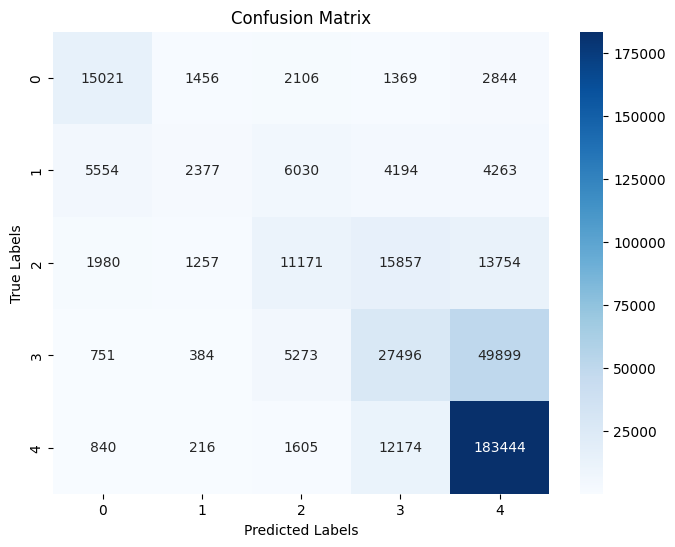

In [12]:
Y_train_labels = Y_train_split
Y_test_labels = Y_test_split

# Training the Random Forest model
rf_model = RandomForestClassifier(
    random_state=0,
    max_features='sqrt',  
    max_depth=None,       
    min_samples_split=2  
)
rf_model.fit(X_train_normalized, Y_train_labels)

# Making predictions on the test set
Y_pred = rf_model.predict(X_test_normalized)

# Calculating accuracy
accuracy = accuracy_score(Y_test_labels, Y_pred)
print(f'Accuracy of the Random Forest model: {accuracy}')

# Calculating and plotting confusion matrix
conf_matrix = confusion_matrix(Y_test_labels, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
X_test = pd.read_csv("./data/X_test.csv")

# Creat Helpfulness coloum
X_test['Helpfulness'] = 0.0
mask = X_test['HelpfulnessNumerator'] > X_test['HelpfulnessDenominator']
X_test.loc[mask, 'Helpfulness'] = 1.0
mask_zero = (X_test['HelpfulnessNumerator'] == 0) | (X_test['HelpfulnessDenominator'] == 0)
X_test.loc[mask_zero, 'Helpfulness'] = 0.0
mask_normal = ~mask & ~mask_zero
X_test.loc[mask_normal, 'Helpfulness'] = X_test.loc[mask_normal, 'HelpfulnessNumerator'] / X_test.loc[mask_normal, 'HelpfulnessDenominator']

# Calculate the average score for each ProductId
X_test['ProductScore'] = X_test.groupby('ProductId')['Score'].transform('mean')
# Calculate the average score for each UserId
X_test['UserScore'] = X_test.groupby('UserId')['Score'].transform('mean')

# Fill the empty string to ensure that all entries are strings
X_test['Summary'].fillna('', inplace=True)
X_test['Text'].fillna('', inplace=True)

# Example processing assuming you have 'Summary' and 'Text' columns
T_tfidf_summary_test = vectorizer_summary.transform(X_test['Summary']).toarray()
T_tfidf_text_test = vectorizer_text.transform(X_test['Text']).toarray()

T_summary_features_test = pd.DataFrame(T_tfidf_summary_test, columns=[f'summary_tfidf_{i}' for i in range(T_tfidf_summary_test.shape[1])])
T_text_features_test = pd.DataFrame(T_tfidf_text_test, columns=[f'text_tfidf_{i}' for i in range(T_tfidf_text_test.shape[1])])

X_test['Summary_sentiment'] = X_test['Summary'].apply(lambda x: TextBlob(x).sentiment.polarity)
X_test['Text_sentiment'] = X_test['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# numeric_features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Helpfulness', 'Time', 'Summary_sentiment', 'Text_sentiment']
X_test = pd.concat([X_test, T_summary_features_test, T_text_features_test], axis=1)
T_X_test_final = pd.concat([X_test[features_to_use]], axis=1)

# Feature normalization
scaler = StandardScaler()
T_X_test_normalized = scaler.fit_transform(T_X_test_final)

# Predict using the trained model
Y_test_predicted = rf_model.predict(T_X_test_normalized)

# Extract Id and combine with predicted Score
submission_df = pd.DataFrame({
    'Id': X_test['Id'], 
    'Score': Y_test_predicted
})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully!")

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22056\3001896483.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test['Summary'].fillna('', inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22056\3001896483.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

Submission file 'submission.csv' created successfully!


# Additional Showcase

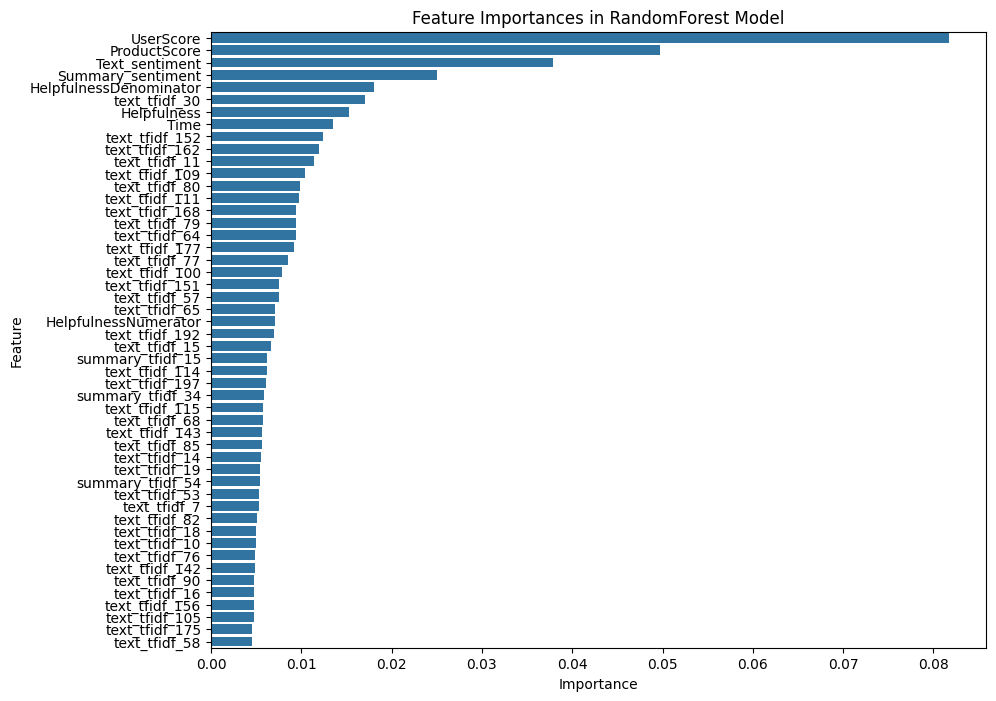

In [24]:
feature_importances = rf_model.feature_importances_
feature_names = X_train_split.columns  

importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

importances_sorted = importances.sort_values(by='Importance', ascending=False).head(50)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances_sorted)
plt.title('Feature Importances in RandomForest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


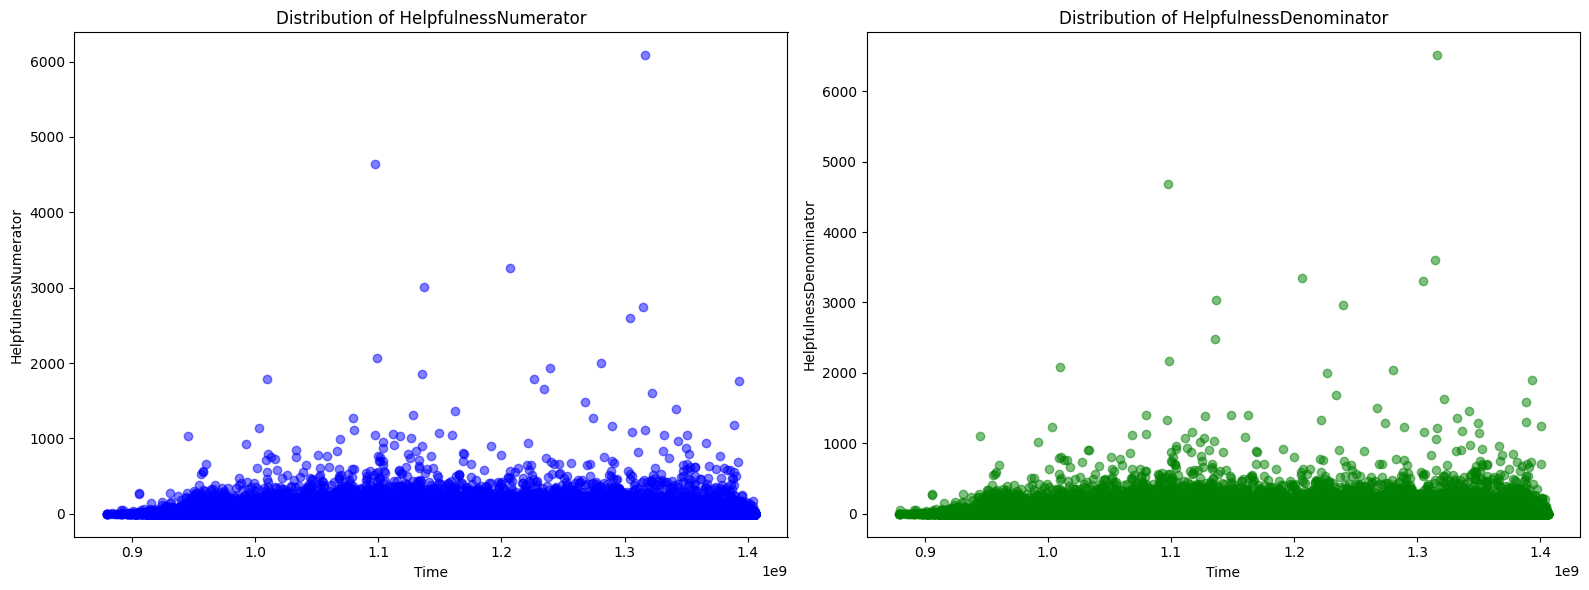

In [15]:
plt.figure(figsize=(16, 6))

# HelpfulnessNumerator
plt.subplot(1, 2, 1)
plt.scatter(X_train['Time'], X_train['HelpfulnessNumerator'], alpha=0.5, c='blue')
plt.title('Distribution of HelpfulnessNumerator')
plt.xlabel('Time')
plt.ylabel('HelpfulnessNumerator')

# HelpfulnessDenominator
plt.subplot(1, 2, 2)
plt.scatter(X_train['Time'], X_train['HelpfulnessDenominator'], alpha=0.5, c='green')
plt.title('Distribution of HelpfulnessDenominator')
plt.xlabel('Time')
plt.ylabel('HelpfulnessDenominator')

plt.tight_layout()
plt.show()

         Time       Date
0  1341014400 2012-06-30
1  1168819200 2007-01-15
2  1386201600 2013-12-05
3  1348704000 2012-09-27
4   970012800 2000-09-27


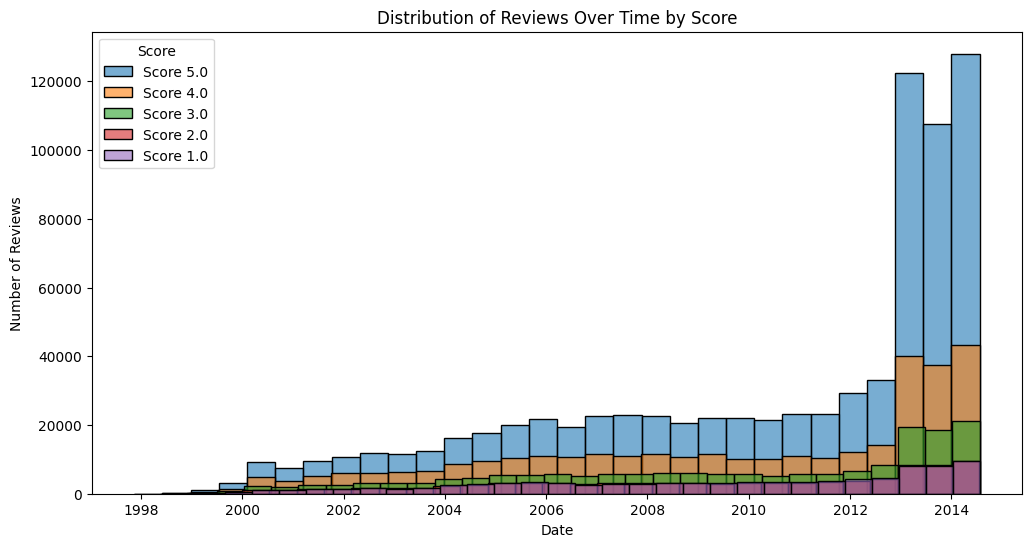

In [16]:
X_train_combined['Date'] = pd.to_datetime(X_train_combined['Time'], unit='s')

print(X_train_combined[['Time', 'Date']].head())
plt.figure(figsize=(12, 6))

for score in sorted(X_train_combined['Score'].unique(), reverse=True):
    sns.histplot(X_train_combined[X_train_combined['Score'] == score]['Date'], kde=False, label=f'Score {score}', alpha=0.6, bins=30)

plt.legend(title='Score')

plt.title('Distribution of Reviews Over Time by Score')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')

plt.show()

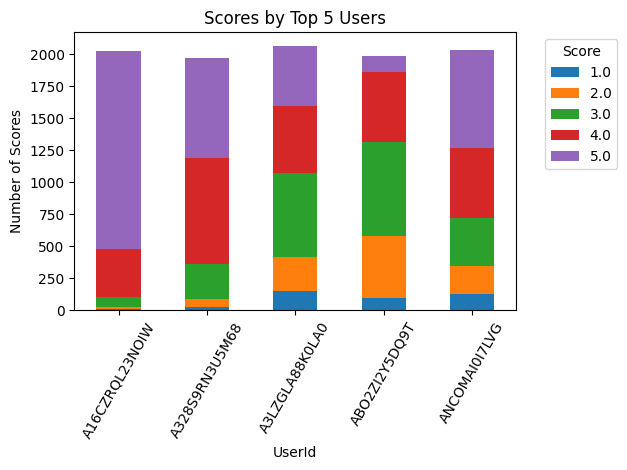

In [22]:
user_counts = X_train['UserId'].value_counts().nlargest(5)

top_users = X_train[X_train['UserId'].isin(user_counts.index)]

score_counts = top_users.pivot_table(index='UserId', columns='Score', aggfunc='size', fill_value=0)


score_counts.plot(kind='bar', stacked=True)
plt.title('Scores by Top 5 Users')
plt.xlabel('UserId')
plt.ylabel('Number of Scores')
plt.legend(title='Score', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=60)
plt.tight_layout()

plt.show()

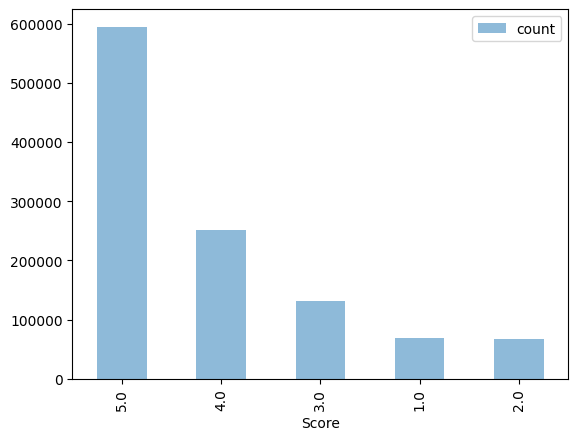

In [25]:
Y_train_split.value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()